In [1]:
import numpy as np
from astropy.table import Table


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Activation

2025-03-06 18:11:16.147774: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 18:11:16.154911: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 18:11:16.252191: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-06 18:11:18.454128: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import numpy as np
from astropy.table import Table

def load_and_preprocess_data(filename):
    data = Table.read(filename, format='ascii.csv', header_start=0, data_start=1)

    # Ensure no NaN or infinity values in sigma_o3_err and sigma_o3
    valid_sigma_o3_err = (data['sigma_o3_err'] > 0) & np.isfinite(data['sigma_o3_err'])  # valid error values
    valid_sigma_o3 = np.isfinite(data['sigma_o3'])  # valid sigma_o3 values
    valid_data = valid_sigma_o3 & valid_sigma_o3_err  # only keep valid data points
    
    # Apply other selection criteria
    ind1 = np.where(data['o3'] / data['o3_err'] > 3)
    ind2 = np.where((data['o21'] + data['o22']) / np.sqrt(data['o21_err']**2 + data['o22_err']**2) > 3)
    ind3 = np.where(data['hb'] / data['hb_err'] > 3)
    ind4 = np.where(data['ha'] / data['ha_err'] > 3)
    ind5 = np.where(data['s21'] / data['s21_err'] > 3)
    ind6 = np.where(valid_data & (data['sigma_o3'] / data['sigma_o3_err'] > 3))  # Only include valid data
    ind7 = np.where(data['VDISP'] > 0.)
    ind8 = np.where(data['mag_u'] > 10.)

    # Combine all indices
    ind = np.array(list(set(ind1[0]) & set(ind2[0]) & set(ind3[0]) & set(ind4[0]) & set(ind5[0]) & set(ind6[0]) & set(ind7[0]) & set(ind8[0])))
    
    # Split into train and test sets
    n_source = len(ind)
    n_split = int(n_source * 0.7)
    ind_train, ind_test = ind[:n_split], ind[n_split:]

    # Compute feature arrays (excluding NII/Halpha, SII/Halpha, and z_w1)
    features_train = {
        'O2_index': np.log10((data['o21'][ind_train] + data['o22'][ind_train]) / data['hb'][ind_train]),
        'O3_index': np.log10(data['o3'][ind_train] / data['hb'][ind_train]),
        'sigma_o3': np.log10(data['sigma_o3'][ind_train]),
        'sigma_star': np.log10(data['VDISP'][ind_train]),
        'u_g': data['mag_u'][ind_train] - data['mag_g'][ind_train],
        'g_r': data['mag_g'][ind_train] - data['mag_r'][ind_train],
        'r_i': data['mag_r'][ind_train] - data['mag_i'][ind_train],
        'i_z': data['mag_i'][ind_train] - data['mag_z'][ind_train],
    }

    features_test = {
        'O2_index': np.log10((data['o21'][ind_test] + data['o22'][ind_test]) / data['hb'][ind_test]),
        'O3_index': np.log10(data['o3'][ind_test] / data['hb'][ind_test]),
        'sigma_o3': np.log10(data['sigma_o3'][ind_test]),
        'sigma_star': np.log10(data['VDISP'][ind_test]),
        'u_g': data['mag_u'][ind_test] - data['mag_g'][ind_test],
        'g_r': data['mag_g'][ind_test] - data['mag_r'][ind_test],
        'r_i': data['mag_r'][ind_test] - data['mag_i'][ind_test],
        'i_z': data['mag_i'][ind_test] - data['mag_z'][ind_test],
    }

    # Assign galaxy type labels
    type_arr_train = np.full(len(ind_train), -999)
    type_arr_test = np.full(len(ind_test), -999)

    ind_sf = np.where(features_train['O3_index'] <= (0.61 / (features_train['O2_index'] - 0.05) + 1.3))
    ind_AGN = np.where(features_train['O3_index'] > (0.61 / (features_train['O2_index'] - 0.47) + 1.19))
    ind_liner = np.where(features_train['O3_index'] > (0.61 / (features_train['O2_index'] - 0.47) + 1.19))
    ind_comp = np.where((features_train['O3_index'] > (0.61 / (features_train['O2_index'] - 0.05) + 1.3)) & 
                         (features_train['O3_index'] < (0.61 / (features_train['O2_index'] - 0.47) + 1.19)))

    type_arr_train[ind_sf] = 1
    type_arr_train[ind_comp] = 2
    type_arr_train[ind_AGN] = 3
    type_arr_train[ind_liner] = 4

    ind_sf_test = np.where(features_test['O3_index'] <= (0.61 / (features_test['O2_index'] - 0.05) + 1.3))
    ind_AGN_test = np.where(features_test['O3_index'] > (0.61 / (features_test['O2_index'] - 0.47) + 1.19))
    ind_liner_test = np.where(features_test['O3_index'] > (0.61 / (features_test['O2_index'] - 0.47) + 1.19))
    ind_comp_test = np.where((features_test['O3_index'] > (0.61 / (features_test['O2_index'] - 0.05) + 1.3)) & 
                              (features_test['O3_index'] < (0.61 / (features_test['O2_index'] - 0.47) + 1.19)))

    type_arr_test[ind_sf_test] = 1
    type_arr_test[ind_comp_test] = 2
    type_arr_test[ind_AGN_test] = 3
    type_arr_test[ind_liner_test] = 4

    return features_train, type_arr_train, features_test, type_arr_test

features_train, type_arr_train, features_test, type_arr_test = load_and_preprocess_data('data_matched_step2_newz_sm.csv')


/tmp/ipykernel_3837649/3401798707.py:18: RuntimeWarning: divide by zero encountered in divide
  ind6 = np.where(valid_data & (data['sigma_o3'] / data['sigma_o3_err'] > 3))  # Only include valid data
/tmp/ipykernel_3837649/3401798707.py:18: RuntimeWarning: invalid value encountered in divide
  ind6 = np.where(valid_data & (data['sigma_o3'] / data['sigma_o3_err'] > 3))  # Only include valid data


In [3]:
from sklearn.model_selection import train_test_split

# features arraay and target vectors (y)
X_train = np.column_stack([features_train['O2_index'], features_train['O3_index'], features_train['sigma_o3'],
                           features_train['sigma_star'], features_train['u_g'], features_train['g_r'], 
                           features_train['r_i'], features_train['i_z']])

X_test = np.column_stack([features_test['O2_index'], features_test['O3_index'], features_test['sigma_o3'],
                          features_test['sigma_star'], features_test['u_g'], features_test['g_r'],
                          features_test['r_i'], features_test['i_z']])

y_train = to_categorical(type_arr_train - 1, num_classes=4)
y_test = to_categorical(type_arr_test - 1, num_classes=4)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(64,input_shape=(X_train_split.shape[1],), activation='relu'))
model.add(Dense(64, name="fc2"))
model.add(Activation(activation="relu"))
model.add(Dense(32, name="fc3"))
model.add(Activation(activation="relu"))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary(show_trainable=True)

/Software/users/modules/7/software/anaconda3/2023.03/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ dense (Dense)               │ (None, 64)            │        576 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ fc2 (Dense)                 │ (None, 64)            │      4,160 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation (Activation)     │ (None, 64)            │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ fc3 (Dense)                 │ (None, 32)            │      2,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_1 (Activation)   │ (None, 32)            │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 32)            │      1,056 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 4)             │        132 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 8,004 (31.27 KB)

 Trainable params: 8,004 (31.27 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
model_history = model.fit(X_train_split, y_train_split, epochs=5, batch_size=32,verbose=1,shuffle=True, validation_data=(X_val_split, y_val_split))
pred = model.predict(X_test,verbose=0)

Epoch 1/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5661 - loss: 0.9562 - val_accuracy: 0.8180 - val_loss: 0.5619
Epoch 2/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8315 - loss: 0.4616 - val_accuracy: 0.9057 - val_loss: 0.2947
Epoch 3/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9169 - loss: 0.2509 - val_accuracy: 0.9364 - val_loss: 0.1997
Epoch 4/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9393 - loss: 0.1749 - val_accuracy: 0.9529 - val_loss: 0.1638
Epoch 5/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9297 - loss: 0.1771 - val_accuracy: 0.9474 - val_loss: 0.1603


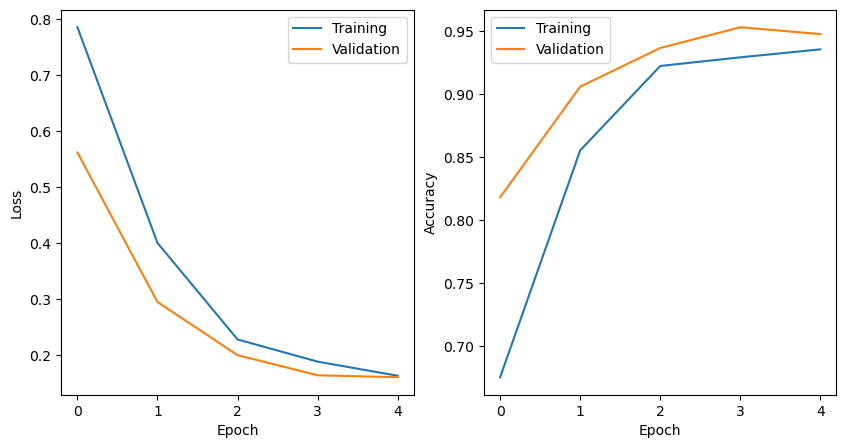

In [5]:
from plotting import plot_model_history

plot_model_history(model_history)

/Software/users/modules/7/software/anaconda3/2023.03/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


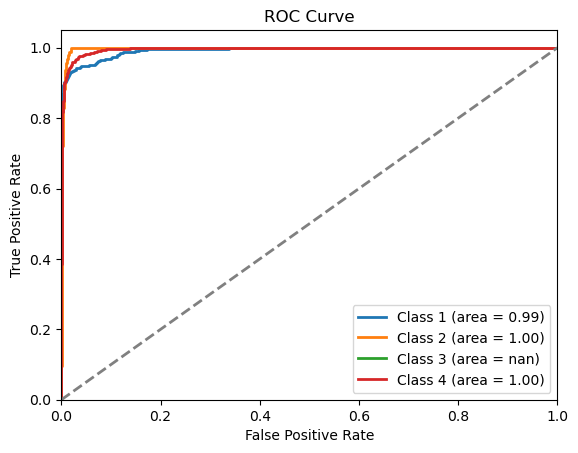

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = pred

fpr = {}
tpr = {}
roc_auc = {}

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()

for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i+1} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.legend(loc='lower right')
plt.show()
